This notebook is for the analysis of the Gulf of Maine NDBC wind data and the cetacean stranding data in Cape Code as a joint dataset.

Approach:

The stranding raw data (dates of stranding reports) will be transformed into a yes/no (1/0) data set spanning the period 1999 - 2014.  The wind raw data (direction and intensity; from a single buoy station, 44005) will be processed into average wind vectors spanning the same time period.  The separate stranding and wind data sets will have to be associated into a single data set, and then I can search the data set for rows with a given wind direction taking the mean of the associated stranding data column.  The mean will be an estimate of the probability for stranding given a certain wind direction.

In addition, I'll look back in time, up to 8 weeks, to see if the winds from prior weeks produce a higher probability of strandings.

Aggregation of data:

For the sake of simplicity, I am choosing to aggregate the stranding data and average wind over 7 day time frames.  So, the stranding event yes/no data will represent whether at least one stranding event occurred over a 7 day period.  And the wind data will be processed from hourly raw data into average weekly wind direction.

Starting and Ending dates:

To choose the starting week for each data set, I note that the first stranding event is recorded on 3/7/1999.  Since January and February usually see a lot of strandings in Cape Cod, I have to assume that the IFAW didn't record strandings before 3/1/1999 and that no strandings occurred from 3/1/99 to 3/6/99.  Since I'll be looking back in time at the wind data (up to 8 weeks), I'll start processing the wind data at 1/4/1999, 56 days before 3/1/99.

The last stranding event occured on 12/4/2014.  I'll assume no strandings occurred through the end of December 2014.  So the stranding data and the wind data will terminate on 12/31/2014.  Since the data is aggregated in 7 day chunks, the last full week ends 12/28/2014 (as counted from 1/4/1999) and I'll stop processing stranding and wind data on 12/28/2014.  (Note: The week ending 12/28/2014 begins on 12/21/2014.  I'll be using the start of the week to tag data, so date stamps will end on 12/21/2014.)

Joining the data:

Once the stranding data and the wind data are processed into weekly chunks, joining the data should be just a matter of aligning the dates and merging into a single two column dataset indexed by date stamps.  For the look-back data, I'll append 8 additional columns of wind direction data, each column shifted down by one row (a week).  Then, for a single date stamp, I'll have a column for whether a stranding occurred that week, a column for the wind direction that week, and 8 more columns for the wind direction in the 8 prior weeks.

The wind data has long periods of data drop out.  These data will be filled with NaN's and I need be sure the stranding data is ignored where there's no wind information.  Another way to deal with this would be to merge wind data from another station.

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as pl
import seaborn as sb
import matplotlib.colors as mcolors
from calendar import month_name
import numpy as np
import warnings
from IPython.display import Image
import math as m
import pandas as pd
#import matplotlib as plt
%matplotlib notebook 
import numpy as np
import scipy as sp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
import datetime as dt
import statsmodels.api as sm

### Read in Strandings Data and Clean

In [2]:
file = './IFAW Mass Stranding Data 1999-2014.xlsx'
# Read the strandings data excel file; only read cols C thru F; use C (Stranding Date) as the index.
s_data = pd.read_excel(file, index_col=0, parse_cols="C:F", names=['End','Comment','Num Stranded'])

In [3]:
s_data.head(5)

,End,Comment,Num Stranded
Event Start Date,,,
2000-04-09,NaN,Collected level A data\n\nCattle ear tag white...,2.0
2000-04-11,NaN,"Skin- Kim Amaral, Dorsal fin to G. Early\n\nS...",2.0
2000-04-11,NaN,Collected level A data\n\nCollected dorsal fin...,2.0
2000-08-14,NaN,Yellow cattle ear tag #265. Release offshore 4...,NaN
2000-08-26,NaN,found in water as herding group of 20-30 La ou...,6.0


In [4]:
# Drop the unused columns, 'End' and 'Comment'
s_data.drop(['End','Comment'], axis=1, inplace=True)

In [5]:
# Change the index tag to 'Date'
s_data.index.names = ['Date']

In [6]:
# Sort the table on the index (Date)
s_data.sort_index(inplace=True)

In [7]:
s_data.head(2)

,Num Stranded
Date,
1999-03-07,6.0
1999-03-18,5.0


In [8]:
s_data.tail(2)

,Num Stranded
Date,
2014-12-04,2.0
2014-12-04,NaN


Remove rows that have duplicate date entries and no data (NaN) for 'Num Stranded'.  Looking at the original file, these types of entries appear to be rows that are part of the same stranding event.  If they were separate stranding events, I'd expect to see a value in the 'Num Stranded' column for each row.

In [9]:
# Keep only non-duplicate entries on index (Date) column where Num Stranded is not NaN.
s_data = s_data.loc[~(s_data.index.duplicated(keep=False) & np.isnan(s_data['Num Stranded'])) ,:]

In [10]:
# See if there are still duplicate Date values
s_data.loc[s_data.index.duplicated(),:]

,Num Stranded
Date,
2000-04-11,2.0
2008-12-25,3.0
2012-02-09,3.0


These duplicates appear to be legit.  Will retain, and need to remember there are duplicate report dates as I proceed with analysis below.

In [11]:
s_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 1999-03-07 to 2014-12-04
Data columns (total 1 columns):
Num Stranded    160 non-null float64
dtypes: float64(1)
memory usage: 2.5 KB


There are still some entries with no data for number of animals stranded.

In [12]:
s_data.loc[np.isnan(s_data['Num Stranded'])]

,Num Stranded
Date,
2000-08-14,NaN
2002-03-24,NaN
2004-12-30,NaN


I'll consider these as legit reports -- the original file has no entry for the number of animals, but there are other fields filled in like comments and location.  Python / Pandas should deal with NaNs correctly, ignoring them for sums, etc.  But, again, need to be careful with further processing below.

In [41]:
# Save binary file of cleaned data to pick up here later if needed.
pickle_file = './strandings_data_clean.pickle'
# s_data = pd.read_pickle(pickle_file)
# s_data.to_pickle(pickle_file)

### Done Ingesting and Cleaning Strandings Data

While I'm here, let's regenerate the stranding frequency by month graph as a sanity check.

In [44]:
# Add a Month column to the data.  Fill with the month number that the report was made.
s_data['Month'] = s_data.index.month

Total number of animals stranded in each month

In [15]:
s_data_bymonth = pd.DataFrame([s_data.loc[s_data['Month'] == i, ['Num Stranded']].sum() for i in range(1,13,1)],
                             index=range(1,13,1), columns=['Num Stranded'])

In [16]:
s_data_bymonth

,Num Stranded
1,246.0
2,140.0
3,162.0
4,70.0
5,12.0
6,2.0
7,82.0
8,45.0
9,15.0
10,18.0


<IPython.core.display.Javascript object>


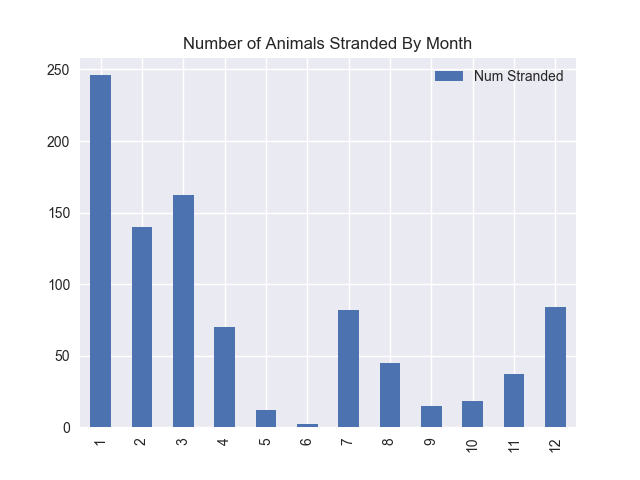

In [20]:
s_data_bymonth.plot(kind='bar', title='Number of Animals Stranded By Month')

Frequency of reports by month

In [18]:
s_data['Month'].value_counts(sort=False)

1     33
2     27
3     28
4     20
5      3
6      1
7      5
8      9
9      5
10     4
11    10
12    18
Name: Month, dtype: int64

<IPython.core.display.Javascript object>


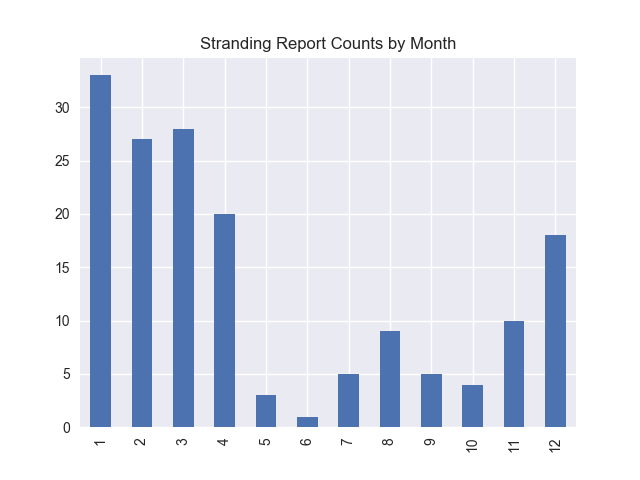

In [21]:
s_data['Month'].value_counts(sort=False).plot(kind='bar', title='Stranding Report Counts by Month')

### Create Binomial Dataset for Strandings

In [45]:
# Drop the Month and Num Stranded columns... not needed anymore.  Assign to new data frame for daily data.
s_d_data = s_data.drop(['Month','Num Stranded'], axis=1)

In [48]:
# Add a column that indicates a report was filed for the index date: 1=Yes, 2=No
s_d_data['Strand'] = 1

Recall there are duplicate dates in the index.  Since I'm reducing the data to just a Stranded flag (1 or 0), I don't need the duplicated report dates.  One entry with the date is sufficient to flag a stranding occurred.

In [49]:
# Here are the duplicates
s_d_data.loc[s_data.index.duplicated()]

,Strand
Date,
2000-04-11,1
2008-12-25,1
2012-02-09,1


In [50]:
# Remove the duplicated dates
s_d_data = s_d_data[~s_d_data.index.duplicated()]

Expand the data from just one row per report date to one row for every day in the time period.

As I explain above, I'm assuming that the stranding data is undetermined prior to 1999-03-01, and that no strandings occurred from 1999-03-01 to 1999-03-06.  (Reasoning: Jan and Feb have the most stranding events, but there's no entries in the oriignal Excel file prior to March.  So I assume they didn't start making stranding reports until March of 1999.)

So I expand the data and fill in new rows with 0 (Strand = No).

In [51]:
start_date = pd.to_datetime('1999-03-01')
end_date = pd.to_datetime('2014-12-31')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

In [53]:
# Expand data from one row per report to one row for every day in study period
# (1999-01-01 to 2014-12-31).  Fill new rows with zero, i.e. no stranding.
s_d_data = s_d_data.reindex(index=date_range, fill_value=0)

In [55]:
s_d_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5785 entries, 1999-03-01 to 2014-12-31
Freq: D
Data columns (total 1 columns):
Strand    5785 non-null int64
dtypes: int64(1)
memory usage: 90.4 KB


In [56]:
s_d_data.loc[s_d_data['Strand']==1].info()  # Still have 160 of the original Stranding = Yes data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 1999-03-07 to 2014-12-04
Data columns (total 1 columns):
Strand    160 non-null int64
dtypes: int64(1)
memory usage: 2.5 KB


In [38]:
# Save binary file of binomial stranding data to pick up here later if needed.
pickle_file = './binomial_strand_data.pickle'
# s_d_d_data = pd.read_pickle(pickle_file)
# s_d_data.to_pickle(pickle_file)

In [62]:
s_d_data.head(8)

,Strand
1999-03-01,0
1999-03-02,0
1999-03-03,0
1999-03-04,0
1999-03-05,0
1999-03-06,0
1999-03-07,1
1999-03-08,0


In [65]:
s_d_data.tail(8)

,Strand
2014-12-24,0
2014-12-25,0
2014-12-26,0
2014-12-27,0
2014-12-28,0
2014-12-29,0
2014-12-30,0
2014-12-31,0


As I also explain above, I'll be working in weekly time spans -- avg wind for a week, stranding y/n in a week.  So I'll transform the daily binomial stranding data into a weekly binomial data set.

Since the first stranding data is 1999-03-01, the start of the last full week of stranding data will be 2014-12-22, producing 826 weekly periods.

In [58]:
# Resample the daily data into 7-day data summing the stranding column values for each 7-day period.
# Create date labels for the data from the start of the 7-day period (label = 'left').
# Reuse the s_data DF variable since we don't need the raw data anymore.
s_data = s_d_data.resample('7D', label='left').sum()

In [59]:
s_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 827 entries, 1999-03-01 to 2014-12-29
Freq: 7D
Data columns (total 1 columns):
Strand    827 non-null int64
dtypes: int64(1)
memory usage: 12.9 KB


In [63]:
s_data.head(5)

,Strand
1999-03-01,1
1999-03-08,0
1999-03-15,4
1999-03-22,1
1999-03-29,0


In [64]:
s_data.tail(5)

,Strand
2014-12-01,1
2014-12-08,0
2014-12-15,0
2014-12-22,0
2014-12-29,0


The last full 7 day week starts on 12/22 and ends 12/28.  Need to throw out the partial week starting 12/29 in the resampled data.

In [66]:
s_data = s_data.loc[:s_data.index[-2]]

In [67]:
s_data.tail()

,Strand
2014-11-24,0
2014-12-01,1
2014-12-08,0
2014-12-15,0
2014-12-22,0


Create a new column 'S' that will be the yes/no indicator for whether a stranding happened in that week.  Since I resampled while summing the stranding flags, the current Strand column has values >= 1 for weeks with a stranding.  Start by making the new column = the Strand column, then replace all the values >1 with 1.

In [68]:
# Create the new column 'S'
s_data['S'] = s_data.loc[:,'Strand']

In [69]:
s_data.head()

,Strand,S
1999-03-01,1,1
1999-03-08,0,0
1999-03-15,4,4
1999-03-22,1,1
1999-03-29,0,0


In [70]:
# Replace values > 1 with 1... could've used the replace() function I think.
s_data.loc[s_data['S'] > 1,'S'] = 1

In [71]:
s_data.head()

,Strand,S
1999-03-01,1,1
1999-03-08,0,0
1999-03-15,4,1
1999-03-22,1,1
1999-03-29,0,0


In [72]:
# Get rid of the 'Strand' column.  No longer needed.
del s_data['Strand']

In [73]:
s_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 826 entries, 1999-03-01 to 2014-12-22
Freq: 7D
Data columns (total 1 columns):
S    826 non-null int64
dtypes: int64(1)
memory usage: 12.9 KB


In [2]:
pickle_file = './binomial_strand_week_data.pickle'
#s_data = pd.read_pickle(pickle_file)
#s_data.to_pickle(pickle_file)

### Done Generating Stranding Dataset

### Ingest Wind Data from Station 44005 (1998 - 2014)

In [2]:
# build list of files prior to 2007
filelist=[]; # file list variable must exist before appending to it.
folder='44005';
for year in range(1998,2007,1):
    filelist += glob.glob('./data/' + str(folder) + '/' + str(folder) + '_' + str(year) + '.txt') # append file strings from each folder

In [3]:
# Read files: use first row as col names; only read first seven columns - if minutes not present, 
# reads extra column (GST) Which can be dropped later; only use first four columns 
# for date and time (i.e. does not use minutes if present); index on new date time column.
filedata = [pd.read_csv(file, delim_whitespace=True, header=0, usecols=[0,1,2,3,4,5,6], parse_dates=[[0,1,2,3]], index_col=0) for file in filelist]

In [4]:
w_data_1 = pd.concat(filedata)

In [5]:
# Drop GST and mm columns
del w_data_1['GST'];
del w_data_1['mm']

In [6]:
w_data_1.head(2)

,WD,WSPD
1998-03-19 00:00:00,231,4.4
1998-03-19 01:00:00,193,4.9


In [7]:
# build list of files after 2007 to 2014
filelist=[]; # file list variable must exist before appending to it.
for year in range(2007,2015,1):
    filelist += glob.glob('./data/' + str(folder) + '/' + str(folder) + '_' + str(year) + '.txt') # append file strings from each folder

In [8]:
# Read files: skip first 2 rows (header) and define col names to be consistent with pre-2007 col names;
# only read first seven columns - min col present so last col is WSPD; only use first four columns 
# for date and time (i.e. does not use minutes); index on new date time column.
filedata = [pd.read_csv(file, delim_whitespace=True, skiprows=2, names=['YYYY','MM','DD','hh','mm','WD','WSPD'], usecols=[0,1,2,3,4,5,6], parse_dates=[[0,1,2,3]], index_col=0) for file in filelist]

In [9]:
w_data_2 = pd.concat(filedata)

In [10]:
# Delete the minute column
del w_data_2['mm']

In [11]:
w_data_2.tail(2)

,WD,WSPD
YYYY_MM_DD_hh,,
2014-12-31 21:00:00,278,7.5
2014-12-31 22:00:00,275,9.1


In [12]:
# Combine pre- and post-2007 data into single data set, concatenating on the index (first file on top of the second).
w_h_data = pd.concat([w_data_1, w_data_2])

In [13]:
w_h_data.head(2)

,WD,WSPD
1998-03-19 00:00:00,231,4.4
1998-03-19 01:00:00,193,4.9


In [82]:
w_h_data.tail(2)

,WD,WSPD
2014-12-31 21:00:00,278,7.5
2014-12-31 22:00:00,275,9.1


Wind data starts on 1998-03-19 and runs through 2014-12-31.  This should be sufficient since we'll be looking at winds prior to stranding reports and the last stranding report is 2014-12-04.

In [14]:
# Presumably missig data has values of 999 in WD ad 99.0 in WSPD.  Replace with NaN.
w_h_data['WD'].replace([999],[None],inplace=True);
w_h_data['WSPD'].replace([99.0],[None],inplace=True);

In [15]:
w_h_data['WD'].max()

360.0

In [16]:
w_h_data['WD'].min()

0.0

In [17]:
w_h_data['WSPD'].max()

24.100000000000001

In [18]:
w_h_data['WD'].min()

0.0

In [19]:
w_h_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117211 entries, 1998-03-19 00:00:00 to 2014-12-31 22:00:00
Data columns (total 2 columns):
WD      106634 non-null float64
WSPD    114158 non-null float64
dtypes: float64(2)
memory usage: 2.7 MB


In [20]:
# Check for duplicated entries
w_h_data.loc[w_h_data.index.duplicated()].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 1998-08-27 00:00:00 to 1998-08-27 23:00:00
Data columns (total 2 columns):
WD      48 non-null float64
WSPD    48 non-null float64
dtypes: float64(2)
memory usage: 1.1 KB


1998-08-27 has dupllicate entries.  This is from the original data file.  ("Not my fault!")  There are three entries for every hour of the day and all the data are the same for each entry.  Need to remove the duplicates.

In [21]:
# Get rid of the duplicated data.
w_h_data = w_h_data.loc[~w_h_data.index.duplicated()]

In [22]:
w_h_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117163 entries, 1998-03-19 00:00:00 to 2014-12-31 22:00:00
Data columns (total 2 columns):
WD      106586 non-null float64
WSPD    114110 non-null float64
dtypes: float64(2)
memory usage: 2.7 MB


In [122]:
# Save binary file of hourly wind data to pick up here later if needed.
pickle_file = './wind_raw_data.pickle'
# w_h_data = pd.read_pickle(pickle_file)
# w_h_data.to_pickle(pickle_file)

### Finished Ingesting Wind Data

### Start Cleaning Wind Data

In [81]:
len(pd.date_range(start='1998-03-19 00:00:00', end='2014-12-31 22:00:00', freq='1H'))

147167

There should be 147167 rows in the data, but there are only 117163.  There's a lot of missing data.  Assume the station was offline or under maintenance.

In [123]:
w_h_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117163 entries, 1998-03-19 00:00:00 to 2014-12-31 22:00:00
Data columns (total 2 columns):
WD      106586 non-null float64
WSPD    114110 non-null float64
dtypes: float64(2)
memory usage: 2.7 MB


In [124]:
# Convert wind direction into radians.  Pandas will ignore missing data putting NaN as result.
w_h_data['WDir'] = w_h_data['WD'] / 180 * np.pi

In [125]:
# Decompose Dir and Speed into X (North-South) and Y (East-West) components.  Again, NaNs ignored.
w_h_data['X'] = np.cos(w_h_data['WDir']) * w_h_data['WSPD'];
w_h_data['Y'] = np.sin(w_h_data['WDir']) * w_h_data['WSPD'];

In [126]:
w_h_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117163 entries, 1998-03-19 00:00:00 to 2014-12-31 22:00:00
Data columns (total 5 columns):
WD      106586 non-null float64
WSPD    114110 non-null float64
WDir    106586 non-null float64
X       106560 non-null float64
Y       106560 non-null float64
dtypes: float64(5)
memory usage: 5.4 MB


Expand the data to fill in the missing rows by reindexing the data and filling in missing rows with NaNs.

In [127]:
# Expand index ...
w_h_data = w_h_data.reindex(index=pd.date_range(start='1998-03-19 00:00:00', end='2014-12-31 22:00:00', freq='1H'))

In [128]:
w_h_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 147167 entries, 1998-03-19 00:00:00 to 2014-12-31 22:00:00
Freq: H
Data columns (total 5 columns):
WD      106586 non-null float64
WSPD    114110 non-null float64
WDir    106586 non-null float64
X       106560 non-null float64
Y       106560 non-null float64
dtypes: float64(5)
memory usage: 6.7 MB


In [3]:
# Save binary file of hourly wind data to pick up here later if needed.
pickle_file = './wind_hr_vec_clean_data.pickle'
# w_h_data = pd.read_pickle(pickle_file)
# w_h_data.to_pickle(pickle_file)

### Generate average weekly wind vector data set.

Need to generate average weekly wind vectors from several weeks before the first stranding to the week of the last stranding.

Since the first report for a stranding is 1999-03-07, I assume that reports could have been generated starting 1999-03-01, i.e. the first days of March 1999 had 'no strandings'.  Jan and Feb of 1999 are undetermined w.r.t. stranding events, but my assumption is that the first week of March, 1999 are no-stranding data.  So I'll start generating wind data 8 weeks (56 days) prior to 1999-03-01 -- wind data starts on 1999-01-04.

The last stranding report is 2014-12-04.  In the same manner, I assume that no strandings occurred for the remaninder of December 2014.  After December 2014, the data is undetermined.  But for the last weeks of December, I'll set the stranding flag to 'no strandings'.  This means I'll need average weekly wind data through 2014-12-31.  Since we're working in 7 day chuncks starting 1999-01-04, wind data will end 2014-12-28, i.e. week starting 2014-12-22.

There will be 834 weeks of wind data.

In [4]:
# Antti wants Daily Avg. Wind file so resample to daily average wind vectors
#w_d_data = w_h_data[['X','Y']].resample('D').mean()

In [5]:
# Save a CSV file for Antti
pickle_file = './wind_vec_clean_day.csv'
#w_d_data.to_csv(pickle_file, columns=['X','Y'], header=['NS','EW'], index_label='DateTime')

In [6]:
# Make sure the hourly data has an entry for the start date-time for the wind data.
w_h_data.loc['1999-01-04 00:00:00']

WD      114.000000
WSPD     17.400000
WDir      1.989675
X        -7.077218
Y        15.895691
Name: 1999-01-04 00:00:00, dtype: float64

In [7]:
# Now resample the hourly wind data into 7-day chunks starting 1/4/99 
# and produce the mean of the X and Y columns within each chunk.  And use the 
# start of the week as the date stamp for each chunk (label = 'left').  NaNs should be ignored.
# Assign the resampled data to w_data.  Now have s_data for strandings and w_data for wind.
w_data = w_h_data.loc['1999-01-04 00:00:00':,['X','Y']].resample('7D', label='left').mean()

Should really consider dropping entries that were derived from partial weeks.  But this gets complicated: how many hours need to be missing to be a partial week?  Just at the beginning or end?  What about gaps mid-week.  Will just ignore this for now.

In [8]:
w_data.head(9)

,X,Y
1999-01-04,-3.580220,-5.159770
1999-01-11,-2.524070,-2.318489
1999-01-18,-3.319277,-0.275190
1999-01-25,4.815033,-2.815019
1999-02-01,1.070875,-1.548679
1999-02-08,-0.288400,-3.873087
1999-02-15,4.679835,-0.057924
1999-02-22,7.033750,-2.295566
1999-03-01,-1.923032,-0.079127


In [9]:
w_data.tail()

,X,Y
2014-12-01,1.114473,-0.993273
2014-12-08,1.835951,1.357680
2014-12-15,4.240149,-0.754856
2014-12-22,-1.739675,-1.257232
2014-12-29,3.590566,-5.465327


In [10]:
# Again drop the last wind entry since it's for a partial week and we won't be using it anyway.
w_data = w_data.loc[:w_data.index[-2]]

In [11]:
w_data.tail()

,X,Y
2014-11-24,-0.111004,-1.127922
2014-12-01,1.114473,-0.993273
2014-12-08,1.835951,1.357680
2014-12-15,4.240149,-0.754856
2014-12-22,-1.739675,-1.257232


In [12]:
# Generate the wind direction from the vectors.  Function arctan2 produces values [-180,180],
# so add 360 to to the negative values to produce directions [0,360], 0=North, 90=East. 
w_data['WDir'] = np.arctan2(w_data['Y'],w_data['X']) * 180 / np.pi
w_data.loc[w_data['WDir'] < 0,'WDir'] += 360

In [13]:
w_data.tail()

,X,Y,WDir
2014-11-24,-0.111004,-1.127922,264.379345
2014-12-01,1.114473,-0.993273,318.291017
2014-12-08,1.835951,1.357680,36.482807
2014-12-15,4.240149,-0.754856,349.905633
2014-12-22,-1.739675,-1.257232,215.854960


In [14]:
w_data.head()

,X,Y,WDir
1999-01-04,-3.580220,-5.159770,235.244297
1999-01-11,-2.524070,-2.318489,222.569079
1999-01-18,-3.319277,-0.275190,184.739354
1999-01-25,4.815033,-2.815019,329.688109
1999-02-01,1.070875,-1.548679,304.662945


In [15]:
lgth = len(w_data.loc[(w_data['WDir'].notnull())])    # 619 non-null wind directions

In [16]:
len(w_data.loc[((w_data['WDir'] >= 0.0) & (w_data['WDir'] < 90.0))]) / lgth

0.1308562197092084

In [17]:
len(w_data.loc[((w_data['WDir'] >= 90) & (w_data['WDir'] < 180))]) / lgth

0.11793214862681745

In [18]:
len(w_data.loc[((w_data['WDir'] >= 180) & (w_data['WDir'] < 270))]) / lgth

0.4345718901453958

In [19]:
len(w_data.loc[((w_data['WDir'] >= 270) & (w_data['WDir'] < 360))]) / lgth

0.3166397415185784

Proportion of wind direction observations --

Total observations: 619

Quadrant 1 (0-90)    observations: 13%

Quadrant 2 (90-180)  observations: 12%

Quadrant 3 (180-270) observations: 43%

Quadrant 4 (270-360) observations: 32%

In [20]:
# Save binary file of weekly wind data to pick up here later if needed.
pickle_file = './wind_week_data.pickle'
# w_data = pd.read_pickle(pickle_file)
# w_data.to_pickle(pickle_file)

### Done Generating average weekly wind vector data set.

### Start Generating combined stranding and wind direction data

In [37]:
s_data.head(2)

,S
1999-03-01,1
1999-03-08,0


In [21]:
w_data.head(2)

,X,Y,WDir
1999-01-04,-3.58022,-5.159770,235.244297
1999-01-11,-2.52407,-2.318489,222.569079


In [34]:
# Append wind data columns to the stranding data.  Function concat() 
# will create needed rows and align the wind data to the stranding index dates (axis=1).
# Each successive column is the original wind data columns shifted by 0 - 8 weeks.
# Finally rename the columns so their not all just 'WDir'.
j_data = pd.concat([s_data, w_data['WDir'], 
                    w_data['WDir'].shift(1,'7D'),
                    w_data['WDir'].shift(2,'7D'),
                    w_data['WDir'].shift(3,'7D'),
                    w_data['WDir'].shift(4,'7D'),
                    w_data['WDir'].shift(5,'7D'),
                    w_data['WDir'].shift(6,'7D'),
                    w_data['WDir'].shift(7,'7D'),
                    w_data['WDir'].shift(8,'7D')
                   ],axis=1)
j_data.columns=['S','WDir','WDir1','WDir2','WDir3','WDir4','WDir5','WDir6','WDir7','WDir8']

In [35]:
j_data.head(10)

,S,WDir,WDir1,WDir2,WDir3,WDir4,WDir5,WDir6,WDir7,WDir8
1999-01-04,NaN,235.244297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-11,NaN,222.569079,235.244297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-18,NaN,184.739354,222.569079,235.244297,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-25,NaN,329.688109,184.739354,222.569079,235.244297,NaN,NaN,NaN,NaN,NaN
1999-02-01,NaN,304.662945,329.688109,184.739354,222.569079,235.244297,NaN,NaN,NaN,NaN
1999-02-08,NaN,265.741469,304.662945,329.688109,184.739354,222.569079,235.244297,NaN,NaN,NaN
1999-02-15,NaN,359.290869,265.741469,304.662945,329.688109,184.739354,222.569079,235.244297,NaN,NaN
1999-02-22,NaN,341.925162,359.290869,265.741469,304.662945,329.688109,184.739354,222.569079,235.244297,NaN
1999-03-01,1.0,182.356209,341.925162,359.290869,265.741469,304.662945,329.688109,184.739354,222.569079,235.244297
1999-03-08,0.0,330.597014,182.356209,341.925162,359.290869,265.741469,304.662945,329.688109,184.739354,222.569079


In [36]:
j_data.tail(10)

,S,WDir,WDir1,WDir2,WDir3,WDir4,WDir5,WDir6,WDir7,WDir8
2014-12-15,0.0,349.905633,36.482807,318.291017,264.379345,255.000560,285.171798,272.922648,347.460243,16.387234
2014-12-22,0.0,215.854960,349.905633,36.482807,318.291017,264.379345,255.000560,285.171798,272.922648,347.460243
2014-12-29,NaN,NaN,215.854960,349.905633,36.482807,318.291017,264.379345,255.000560,285.171798,272.922648
2015-01-05,NaN,NaN,NaN,215.854960,349.905633,36.482807,318.291017,264.379345,255.000560,285.171798
2015-01-12,NaN,NaN,NaN,NaN,215.854960,349.905633,36.482807,318.291017,264.379345,255.000560
2015-01-19,NaN,NaN,NaN,NaN,NaN,215.854960,349.905633,36.482807,318.291017,264.379345
2015-01-26,NaN,NaN,NaN,NaN,NaN,NaN,215.854960,349.905633,36.482807,318.291017
2015-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.854960,349.905633,36.482807
2015-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.854960,349.905633
2015-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.854960


In [38]:
# Trim the joint data set down to only the stranding data time period: 
# from the week beginning 1999-03-01 to the week beginning 2014-12-22
j_data = j_data.loc['1999-03-01':'2014-12-22']

In [39]:
j_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 826 entries, 1999-03-01 to 2014-12-22
Freq: 7D
Data columns (total 10 columns):
S        826 non-null float64
WDir     611 non-null float64
WDir1    611 non-null float64
WDir2    611 non-null float64
WDir3    611 non-null float64
WDir4    611 non-null float64
WDir5    611 non-null float64
WDir6    611 non-null float64
WDir7    611 non-null float64
WDir8    611 non-null float64
dtypes: float64(10)
memory usage: 71.0 KB


In [40]:
pickle_file = './joint_week_data.pickle'
j_data.to_pickle(pickle_file)
#j_data = pd.read_pickle(pickle_file)

In [41]:
# Create a function to help me look for winds in a range of directions
# then return the number of observations found (n) and the mean of the stranding column (p).
def p_sw(df,scol,wcol,dir1,dir2):
    p = df.loc[((df[wcol] >= dir1) & (df[wcol] < dir2)),scol].mean()
    n = len(df.loc[((df[wcol] >= dir1) & (df[wcol] < dir2)),scol])
    return n,p

In [42]:
# Going to have two nested for loops: one over the offset weeks, the other over the wind directions.
# Create two sets of multi-parameter lists for the loops.

# Wind col name and number of weeks offset:
wind_cols = [('WDir',0),('WDir1',1),('WDir2',2),('WDir3',3),('WDir4',4),('WDir5',5),('WDir6',6),('WDir7',7),('WDir8',8)]

# Starting direction, ending direction, direction wedge identifier.
wedges =[[0,90,1],[90,180,2],[180,270,3],[270,360,4]]

In [43]:
# Create a dataset of the week offset, the direction ID, the number of observations
# and the mean strandings value for those observations, i.e. the probability of stranding
# for the given wind direction.  This will be a multi-index data frame: Offset then dir. ID
prob_df = pd.DataFrame([(offset,direct[2]) + p_sw(j_data,'S',wcol,direct[0],direct[1]) 
              for (wcol,offset) in wind_cols 
              for direct in wedges],
            columns=['Offset','Quad','n','p']).set_index(['Offset','Quad'])

In [44]:
prob_df.head(8)

n         p
Offset Quad               
0      1      81  0.172840
       2      73  0.054795
       3     265  0.109434
       4     192  0.187500
1      1      81  0.148148
       2      73  0.109589
       3     264  0.087121
       4     193  0.207254

In [1]:
0.172840 + 0.054795 + 0.109434 + 0.187500 + 0.148148 + 0.109589 + 0.087121 + 0.207254

1.076681

In [2]:
81+73+265+192 + 81 +73 + 264 + 193

1222

In [3]:
81/1222

0.0662847790507365

This is my first multi-level index, so I'm just playing around with how to access data...

In [433]:
idx=pd.IndexSlice

In [451]:
prob_df.loc[(slice(None),slice(3,3)),'p'].values

array([ 0.10943396,  0.08712121,  0.09090909,  0.12075472,  0.11320755,
        0.11363636,  0.13257576,  0.13207547,  0.14285714])

In [453]:
prob_df.loc[idx[:,3],'p']

Offset  Quad
0       3       0.109434
1       3       0.087121
2       3       0.090909
3       3       0.120755
4       3       0.113208
5       3       0.113636
6       3       0.132576
7       3       0.132075
8       3       0.142857
Name: p, dtype: float64

Going to make some plots now.  Will need the unstack() function.  Here's an example of it.

In [46]:
prob_df.unstack(level=1)

n                       p                              
Quad     1   2    3    4         1         2         3         4
Offset                                                          
0       81  73  265  192  0.172840  0.054795  0.109434  0.187500
1       81  73  264  193  0.148148  0.109589  0.087121  0.207254
2       81  73  264  193  0.123457  0.109589  0.090909  0.217617
3       80  73  265  193  0.137500  0.082192  0.120755  0.181347
4       80  73  265  193  0.125000  0.054795  0.113208  0.207254
5       80  73  264  194  0.150000  0.095890  0.113636  0.195876
6       80  73  264  194  0.125000  0.054795  0.132576  0.190722
7       80  73  265  193  0.125000  0.041096  0.132075  0.196891
8       80  73  266  192  0.075000  0.068493  0.142857  0.203125

In [47]:
prob_df.unstack(level=1)['p',2]

Offset
0    0.054795
1    0.109589
2    0.109589
3    0.082192
4    0.054795
5    0.095890
6    0.054795
7    0.041096
8    0.068493
Name: (p, 2), dtype: float64

Ok, Let's make some plots: bar graphs of the probability of stranding in each direction with the number of offset weeks on the x-axis.

<IPython.core.display.Javascript object>


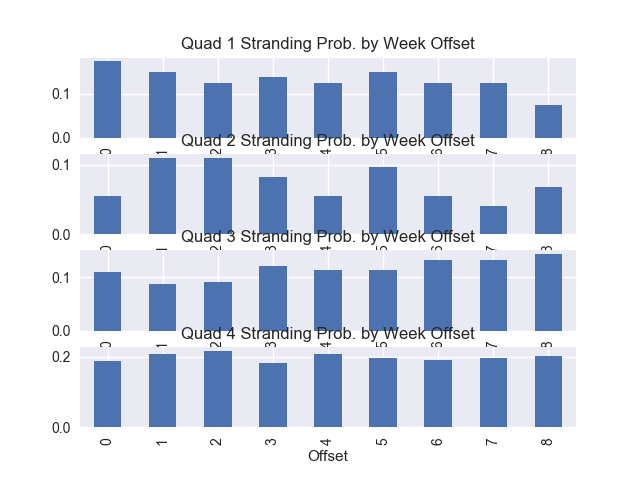

In [48]:
f,a = pl.subplots(4,1)
prob_df.unstack(level=1)['p',1].plot(kind='bar', ax=a[0], title='Quad 1 Stranding Prob. by Week Offset',ylim=0)
prob_df.unstack(level=1)['p',2].plot(kind='bar', ax=a[1], title='Quad 2 Stranding Prob. by Week Offset',ylim=0)
prob_df.unstack(level=1)['p',3].plot(kind='bar', ax=a[2], title='Quad 3 Stranding Prob. by Week Offset',ylim=0)
prob_df.unstack(level=1)['p',4].plot(kind='bar', ax=a[3], title='Quad 4 Stranding Prob. by Week Offset',ylim=0)

<IPython.core.display.Javascript object>


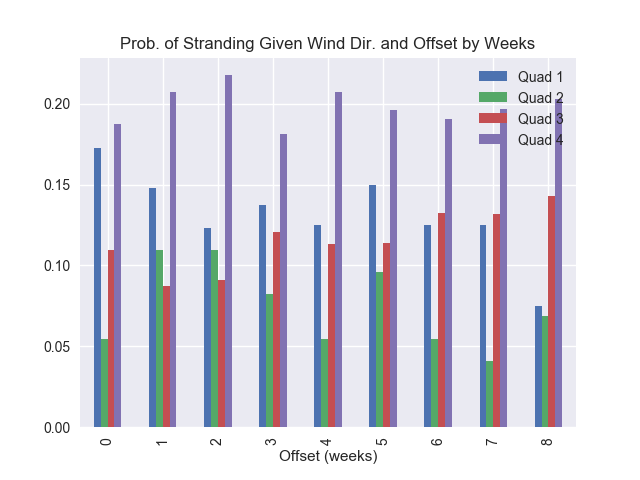

In [49]:
pd.DataFrame([prob_df.unstack(level=1)['p',1].values,
              prob_df.unstack(level=1)['p',2].values,
              prob_df.unstack(level=1)['p',3].values,
              prob_df.unstack(level=1)['p',4].values],
             index=['Quad 1', 'Quad 2', 'Quad 3', 'Quad 4']
            ).T.rename_axis('Offset (weeks)').plot(kind='bar',title='Prob. of Stranding Given Wind Dir. and Offset by Weeks')